<a href="https://colab.research.google.com/github/samsontran/Hand-Gesture-Recognition/blob/main/Hand_Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### American Sign Language

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing.

The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

In Part 1 of this project, I write build a Convolutional Neural Network from scratch to train a model to recognize American Sign Language alphabets from A to I. 

In Part 2, I apply transfer learning using the neural network component of  AlexNet network to compute the convolutional features and get pre-trained weights. As you will see, the test accuracy goes up to 93%!

In Part 3, I take my own American Sign Language hand gesture photos and test it out in my model (spoiler: my model accurately predicts all of them!)

Dataset source: I use a labelled training set that was made available from my graduate level course, MIE1517 Deep Learning. 

### Part 0. Data Loading and Splitting 

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
import os, shutil
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
main = '/content/gdrive/MyDrive/Gesture_Dataset/'

#create main directory folders for test, val, and train
testMain = "/content/gdrive/MyDrive/Lab_2B/test"
valMain = "/content/gdrive/MyDrive/Lab_2B/val"
trainMain = "/content/gdrive/MyDrive/Lab_2B/train"
if not os.path.exists(testMain):
    os.makedirs(testMain)
if not os.path.exists(valMain):
    os.makedirs(valMain)
if not os.path.exists(trainMain):
    os.makedirs(trainMain)

In [ ]:
#for each class, create a subfolder in the 'train' main directory folder
#split the data into 64% training, 16% validation, 20% testing

for subclass in os.listdir(main):
  subfolder = os.path.join(main, str(subclass))
  files_in_subfolder = sorted(os.listdir(subfolder))

  trainSub = os.path.join(trainMain, subclass)
  if not os.path.exists(trainSub):
    os.makedirs(trainSub)

  for file in files_in_subfolder[:math.floor(len(files_in_subfolder)*0.8*0.8)]:
    shutil.copy(subfolder + '/' + file, trainSub + '/' + file)

  #repeat similar process for the validation (add the next 16% of photos in each class to the validation set)
  valSub = os.path.join(valMain, subclass)
  if not os.path.exists(valSub):
    os.makedirs(valSub)

  for file in files_in_subfolder[math.floor(len(files_in_subfolder)*0.8*0.8):math.floor(len(files_in_subfolder)*0.8)]:
    shutil.copy(subfolder + '/' + file, valSub + '/' + file)

  #repeat similar process for the test (add last 20% of photos into the testing set) 
  testSub = os.path.join(testMain, subclass)
  if not os.path.exists(testSub):
    os.makedirs(testSub)

  for file in files_in_subfolder[math.floor(len(files_in_subfolder)*0.8):]:
    shutil.copy(subfolder + '/' + file, testSub + '/' + file)

In [ ]:
# define transform 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([224, 224]), #ensure all photos will be 224x224
    transforms.CenterCrop(224), #assume photos have hand centered
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]) #normalize with mean and std values of 0.5

# construct and transform the training, validation, and testing datasets separately 
train_dataset = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/Lab_2B/train',
                                           transform=transform)
val_dataset = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/Lab_2B/val',
                                           transform=transform)
test_dataset = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/Lab_2B/test',
                                           transform=transform)

Visualize the data...

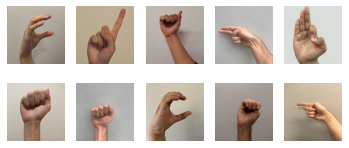

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle = True)

k = 0
for images, labels in train_loader:
    image = images[0]

    image = images[0]
    img = np.transpose(image, [1,2,0])
    img = img / 2 + 0.5

    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img.numpy())

    k += 1
    if k > 9:
        break

###Part 1: Building & training a CNN model

I'll define a model as follows:

In [ ]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()
    self.conv1 = nn.Conv2d(3, 3, 5)
    self.pool = nn.MaxPool2d(5, 5)
    self.conv2 = nn.Conv2d(3, 3, 5)
    self.fc1 = nn.Linear(192, 32)
    self.fc2 = nn.Linear(32,9)

  def forward(self, x):
    x = self.pool(F.relu((self.conv1(x))))
    x = self.pool(F.relu((self.conv2(x))))
    x = x.view(-1, 192)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = x.squeeze(1)

    return x

Now, train the model

In [ ]:
def train(model, training_data, val_data, batch_size = 128, learning_rate = 0.01, num_epochs = 20, sanity_check = False):

  train_loader = torch.utils.data.DataLoader(dataset=training_data, shuffle = True, batch_size=batch_size)

  #define criterion & optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr = learning_rate)
  
  train_losses_list=[]
  train_accu_list=[]

  eval_losses_list=[]
  eval_accu_list=[]

  for epoch in range(1,num_epochs+1): 
      print('\nEpoch : %d'%epoch)

      running_loss=0
      incorrect=0
      total=0

      eval_running_loss=0
      eval_incorrect=0
      eval_total=0

      for data in tqdm(train_loader):
        
            inputs,labels=data

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()
            #############################################
            
            outputs=model(inputs)
            loss=criterion(outputs,labels)
            loss.backward()  
            optimizer.step()              
            optimizer.zero_grad()

            running_loss += loss.item()
            
            _, predicted = outputs.max(1)
            total += labels.size(0)
            incorrect += predicted.ne(labels).sum().item()

          
      train_loss=running_loss/len(train_loader)
      train_accu=100.*incorrect/total
      
      train_accu_list.append(train_accu)
      train_losses_list.append(train_loss)
      print('Train Loss: %.3f | Error: %.3f'%(train_loss,train_accu))

      if sanity_check == False:
            testloader = torch.utils.data.DataLoader(dataset=val_data, shuffle = True, batch_size=batch_size)

            for data in tqdm(testloader):
                inputs,labels=data

                #############################################
                #To Enable GPU Usage
                if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()
                  labels = labels.cuda()
                #############################################

                outputs=model(inputs)

                loss= criterion(outputs,labels)
                eval_running_loss+=loss.item()

                _, predicted = outputs.max(1)
                eval_total += labels.size(0)
                eval_incorrect += predicted.ne(labels).sum().item()

            test_loss=eval_running_loss/len(testloader)
            eval_accu=100.*eval_incorrect/eval_total

            eval_losses_list.append(test_loss)
            eval_accu_list.append(eval_accu)

            print('Val Loss: %.3f | Error: %.3f'%(test_loss,eval_accu))

  return train_losses_list, train_accu_list, eval_losses_list, eval_accu_list

In [ ]:
def plot_training_curve(train_loss, train_err, val_loss, val_err):

    plt.plot(train_err)
    plt.plot(val_err)
    plt.xlabel('epoch')
    plt.ylabel('Error')
    plt.legend(['Train','Valid'])
    plt.title('Train vs Valid Error')

    plt.show()

    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.xlabel('epoch')
    plt.ylabel('losses')
    plt.legend(['Train','Valid'])
    plt.title('Train vs Validation Losses')

    plt.show()


Epoch : 1


100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


Train Loss: 1.966 | Error: 72.018


100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Val Loss: 1.421 | Error: 47.692

Epoch : 2


100%|██████████| 13/13 [00:10<00:00,  1.21it/s]


Train Loss: 1.384 | Error: 45.197


100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Val Loss: 1.272 | Error: 43.590

Epoch : 3


100%|██████████| 13/13 [00:10<00:00,  1.21it/s]


Train Loss: 1.159 | Error: 38.169


100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Val Loss: 0.857 | Error: 33.077

Epoch : 4


100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


Train Loss: 1.000 | Error: 32.753


100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Val Loss: 0.879 | Error: 33.077

Epoch : 5


100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Train Loss: 0.856 | Error: 27.724


100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Val Loss: 0.903 | Error: 35.897

Epoch : 6


100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


Train Loss: 0.830 | Error: 25.661


100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Val Loss: 0.997 | Error: 31.795

Epoch : 7


100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


Train Loss: 0.787 | Error: 26.048


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Val Loss: 0.988 | Error: 31.795

Epoch : 8


100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


Train Loss: 0.686 | Error: 22.244


100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Val Loss: 0.889 | Error: 34.103

Epoch : 9


100%|██████████| 13/13 [00:10<00:00,  1.21it/s]


Train Loss: 0.617 | Error: 19.536


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Val Loss: 1.186 | Error: 29.487

Epoch : 10


100%|██████████| 13/13 [00:10<00:00,  1.21it/s]


Train Loss: 0.584 | Error: 19.278


100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Val Loss: 1.124 | Error: 31.538

Epoch : 11


100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


Train Loss: 0.591 | Error: 20.245


100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Val Loss: 1.076 | Error: 27.179

Epoch : 12


100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


Train Loss: 0.558 | Error: 18.246


100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Val Loss: 1.198 | Error: 34.103

Epoch : 13


100%|██████████| 13/13 [00:10<00:00,  1.20it/s]


Train Loss: 0.559 | Error: 17.859


100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Val Loss: 0.895 | Error: 26.923

Epoch : 14


100%|██████████| 13/13 [00:10<00:00,  1.21it/s]


Train Loss: 0.435 | Error: 13.540


100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Val Loss: 1.055 | Error: 26.410

Epoch : 15


100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


Train Loss: 0.380 | Error: 11.928


100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Val Loss: 1.078 | Error: 22.308

Epoch : 16


100%|██████████| 13/13 [00:10<00:00,  1.20it/s]


Train Loss: 0.352 | Error: 11.219


100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


Val Loss: 0.857 | Error: 24.103


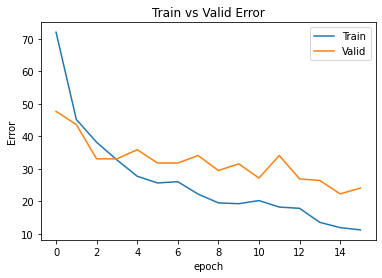

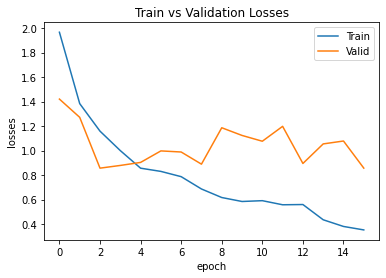

Lowest Validation Error: 22.307692307692307, at Epoch 15
Lowest Validation Loss: 0.8565678894519806, at Epoch 15


In [ ]:
use_cuda = True

model = Classifier()

if use_cuda and torch.cuda.is_available():
  model3.cuda()

train_loss, train_err, val_loss, val_err = train(model3, train_dataset, val_dataset, learning_rate = 0.005, num_epochs=16)

plot_training_curve(train_loss, train_err, val_loss, val_err)

print("Lowest Validation Error: {}, at Epoch {}".format(min(val_err), np.argmin(val_err) + 1))
print("Lowest Validation Loss: {}, at Epoch {}".format(min(val_loss), np.argmin(val_err) + 1))

Reporting test accuracy on test set:

In [ ]:
criterion = nn.CrossEntropyLoss()

eval_total = 0
eval_incorrect = 0

eval_accu_list = []

testloader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle = True, batch_size=128)

for data in tqdm(testloader):
    inputs,labels=data

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      inputs = inputs.cuda()
      labels = labels.cuda()
    #############################################

    outputs=model3(inputs)

    loss= criterion(outputs,labels)

    _, predicted = outputs.max(1)
    eval_total += labels.size(0)
    eval_incorrect += predicted.ne(labels).sum().item()

eval_accu=100.*eval_incorrect/eval_total

eval_accu_list.append(eval_accu)

print('Val Error: %.3f'%(eval_accu))

100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

Val Error: 24.898


In [ ]:
print("Test accuracy is: ", 100 - eval_accu)

Test accuracy is:  75.10204081632654


### Part 2. Transfer Learning with AlexNet

In [ ]:
import torchvision.models
alexNet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
#Computing the AlexNet features for each of the training, validation, and test data

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

train_features = torch.FloatTensor([])
train_labels = torch.FloatTensor([])
for images, labels in iter(train_loader):
  train_features = torch.cat((train_features, alexNet.features(images)), 0)
  train_labels = torch.cat((train_labels, labels), 0)

val_features = torch.FloatTensor([])
val_labels = torch.FloatTensor([])
for images, labels in iter(val_loader):
  val_features = torch.cat((val_features, alexNet.features(images)), 0)
  val_labels = torch.cat((val_labels, labels), 0)

test_features = torch.FloatTensor([])
test_labels = torch.FloatTensor([])
for images, labels in iter(test_loader):
  test_features = torch.cat((test_features, alexNet.features(images)), 0)
  test_labels = torch.cat((test_labels, labels), 0)

In [ ]:
#saving the features to my drive

path = F"/content/gdrive/My Drive/lab_2_features/" 

if not os.path.exists(path):
    os.makedirs(path)

torch.save(train_features, path + 'train_features.pt')
torch.save(val_features, path + 'val_features.pt')
torch.save(test_features, path + 'test_features.pt')

torch.save(train_labels, path + 'train_labels.pt')
torch.save(val_labels, path + 'val_labels.pt')
torch.save(test_labels, path + 'test_labels.pt')

In [ ]:
#loading the features from my drive

path = F"/content/gdrive/My Drive/lab_2_features/" 

train_features = torch.load(path + 'train_features.pt')
val_features = torch.load(path + 'val_features.pt')
test_features = torch.load(path + 'test_features.pt')

train_labels = torch.load(path + 'train_labels.pt')
val_labels = torch.load(path + 'val_labels.pt')
test_labels = torch.load(path + 'test_labels.pt')

In [ ]:
#because the AlexNet feature computation split the features and labels apart, I'll need to combine features and label data into one matrix back again

train_featlabels = []
val_featlabels = []
test_featlabels = []

for i in range(len(train_features)):
  train_featlabels.append([train_features[i], train_labels[i].type(torch.LongTensor)])

for i in range(len(val_features)):
  val_featlabels.append([val_features[i], val_labels[i].type(torch.LongTensor)])

for i in range(len(test_features)):
  test_featlabels.append([test_features[i], test_labels[i].type(torch.LongTensor)])  


In [ ]:
class AlexNetClassifier(nn.Module):
  def __init__(self):
    super(AlexNetClassifier, self).__init__()
    self.conv1 = nn.Conv2d(256, 128, 2)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(128*2*2, 32)
    self.fc2 = nn.Linear(32,9)
    
  def forward(self, features):
    x = self.pool(F.relu((self.conv1(features))))
    x = x.view(-1, 128*2*2)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = x.squeeze(1)

    return x

Training this AlexNet model:


Epoch : 1


100%|██████████| 13/13 [00:49<00:00,  3.84s/it]


Train Loss: 1.390 | Error: 48.162


100%|██████████| 4/4 [00:00<00:00, 41.01it/s]


Val Loss: 0.591 | Error: 23.590

Epoch : 2


100%|██████████| 13/13 [00:49<00:00,  3.84s/it]


Train Loss: 0.502 | Error: 16.505


100%|██████████| 4/4 [00:00<00:00, 42.35it/s]


Val Loss: 0.461 | Error: 15.385

Epoch : 3


100%|██████████| 13/13 [00:49<00:00,  3.83s/it]


Train Loss: 0.288 | Error: 9.929


100%|██████████| 4/4 [00:00<00:00, 41.03it/s]


Val Loss: 0.424 | Error: 12.308

Epoch : 4


100%|██████████| 13/13 [00:49<00:00,  3.83s/it]


Train Loss: 0.183 | Error: 5.287


100%|██████████| 4/4 [00:00<00:00, 35.39it/s]


Val Loss: 0.339 | Error: 12.564

Epoch : 5


100%|██████████| 13/13 [00:49<00:00,  3.82s/it]


Train Loss: 0.135 | Error: 3.353


100%|██████████| 4/4 [00:00<00:00, 38.91it/s]


Val Loss: 0.352 | Error: 15.641

Epoch : 6


100%|██████████| 13/13 [00:49<00:00,  3.83s/it]


Train Loss: 0.103 | Error: 2.772


100%|██████████| 4/4 [00:00<00:00, 39.01it/s]


Val Loss: 0.336 | Error: 11.026

Epoch : 7


100%|██████████| 13/13 [00:49<00:00,  3.83s/it]


Train Loss: 0.072 | Error: 1.225


100%|██████████| 4/4 [00:00<00:00, 42.45it/s]


Val Loss: 0.250 | Error: 10.256

Epoch : 8


100%|██████████| 13/13 [00:49<00:00,  3.82s/it]


Train Loss: 0.043 | Error: 0.774


100%|██████████| 4/4 [00:00<00:00, 40.97it/s]


Val Loss: 0.418 | Error: 9.744

Epoch : 9


100%|██████████| 13/13 [00:49<00:00,  3.83s/it]


Train Loss: 0.027 | Error: 0.258


100%|██████████| 4/4 [00:00<00:00, 40.45it/s]


Val Loss: 0.252 | Error: 10.000

Epoch : 10


100%|██████████| 13/13 [00:49<00:00,  3.83s/it]


Train Loss: 0.018 | Error: 0.129


100%|██████████| 4/4 [00:00<00:00, 35.01it/s]


Val Loss: 0.231 | Error: 9.487

Epoch : 11


100%|██████████| 13/13 [00:49<00:00,  3.83s/it]


Train Loss: 0.011 | Error: 0.000


100%|██████████| 4/4 [00:00<00:00, 41.12it/s]


Val Loss: 0.208 | Error: 9.231

Epoch : 12


100%|██████████| 13/13 [00:49<00:00,  3.82s/it]


Train Loss: 0.008 | Error: 0.000


100%|██████████| 4/4 [00:00<00:00, 38.60it/s]


Val Loss: 0.282 | Error: 9.744

Epoch : 13


100%|██████████| 13/13 [00:49<00:00,  3.83s/it]


Train Loss: 0.005 | Error: 0.000


100%|██████████| 4/4 [00:00<00:00, 43.00it/s]


Val Loss: 0.265 | Error: 10.256

Epoch : 14


100%|██████████| 13/13 [00:50<00:00,  3.85s/it]


Train Loss: 0.004 | Error: 0.000


100%|██████████| 4/4 [00:00<00:00, 42.57it/s]


Val Loss: 0.251 | Error: 9.231

Epoch : 15


100%|██████████| 13/13 [00:49<00:00,  3.83s/it]


Train Loss: 0.003 | Error: 0.000


100%|██████████| 4/4 [00:00<00:00, 41.11it/s]


Val Loss: 0.232 | Error: 10.000

Epoch : 16


100%|██████████| 13/13 [00:49<00:00,  3.82s/it]


Train Loss: 0.003 | Error: 0.000


100%|██████████| 4/4 [00:00<00:00, 41.63it/s]


Val Loss: 0.233 | Error: 9.487

Epoch : 17


100%|██████████| 13/13 [00:49<00:00,  3.84s/it]


Train Loss: 0.003 | Error: 0.000


100%|██████████| 4/4 [00:00<00:00, 38.04it/s]


Val Loss: 0.345 | Error: 10.000

Epoch : 18


100%|██████████| 13/13 [00:49<00:00,  3.83s/it]


Train Loss: 0.002 | Error: 0.000


100%|██████████| 4/4 [00:00<00:00, 41.10it/s]


Val Loss: 0.248 | Error: 10.000

Epoch : 19


100%|██████████| 13/13 [00:49<00:00,  3.84s/it]


Train Loss: 0.002 | Error: 0.000


100%|██████████| 4/4 [00:00<00:00, 40.00it/s]


Val Loss: 0.307 | Error: 10.000

Epoch : 20


100%|██████████| 13/13 [00:49<00:00,  3.83s/it]


Train Loss: 0.002 | Error: 0.000


100%|██████████| 4/4 [00:00<00:00, 38.53it/s]


Val Loss: 0.236 | Error: 9.487


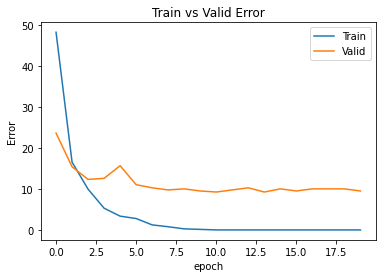

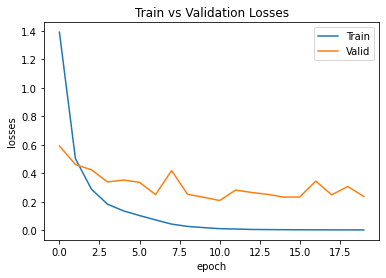

Lowest Validation Error: 9.23076923076923, at Epoch 11
Lowest Validation Loss: 0.208354405593127, at Epoch 11


In [ ]:
use_cuda = True

model = NewClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()

train_loss, train_err, val_loss, val_err = train(model, train_featlabels, val_featlabels, learning_rate = 0.0025)

plot_training_curve(train_loss, train_err, val_loss, val_err)

print("Lowest Validation Error: {}, at Epoch {}".format(min(val_err), np.argmin(val_err) + 1))
print("Lowest Validation Loss: {}, at Epoch {}".format(min(val_loss), np.argmin(val_err) + 1))

Reporting test accuracy on the test set:

In [ ]:
model = model #use last model, which had the best error at the last epoch

criterion = nn.CrossEntropyLoss()

eval_total = 0
eval_incorrect = 0

eval_accu_list = []

testloader = torch.utils.data.DataLoader(dataset=test_featlabels, shuffle = True, batch_size=128)

for data in tqdm(testloader):
    inputs,labels=data

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      inputs = inputs.cuda()
      labels = labels.cuda()
    #############################################

    outputs=model(inputs)

    loss= criterion(outputs,labels)

    _, predicted = outputs.max(1)
    eval_total += labels.size(0)
    eval_incorrect += predicted.ne(labels).sum().item()

eval_accu=100.*eval_incorrect/eval_total

eval_accu_list.append(eval_accu)

print('Test Error: %.3f'%(eval_accu))

print('Test Accuracy: ', 100-eval_accu)

100%|██████████| 4/4 [00:00<00:00, 32.85it/s]

Test Error: 7.143
Test Accuracy:  92.85714285714286


Before transfer learning, the test accuracy was 0.75102. This is a 23% increase!

### Part 3. Testing on my own images

In this section, I take my own American Sign Language hand gesture photos and test them on my model. This set contains 27 images (3 photos of alphabets A to I)


In [ ]:
# define transform 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([224, 224]), #ensure all photos will be 224x224
    transforms.CenterCrop(224), #assume photos have hand centered
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]) #normalize with mean and std values of 0.5

my_dataset = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/My_Hand_Gestures',
                                           transform=transform)

In [ ]:
test_loader = torch.utils.data.DataLoader(my_dataset, batch_size=128)

test_features = torch.FloatTensor([])
test_labels = torch.FloatTensor([])
for images, labels in iter(test_loader):
  test_features = torch.cat((test_features, alexNet.features(images)), 0)
  test_labels = torch.cat((test_labels, labels), 0)

test_featlabels = []
for i in range(len(test_features)):
  test_featlabels.append([test_features[i], test_labels[i].type(torch.LongTensor)])

In [ ]:
criterion = nn.CrossEntropyLoss()

eval_total = 0
eval_incorrect = 0

eval_accu_list = []

testloader = torch.utils.data.DataLoader(dataset=test_featlabels, shuffle = True, batch_size=128)

for data in tqdm(testloader):
    inputs,labels=data

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      inputs = inputs.cuda()
      labels = labels.cuda()
    #############################################

    outputs=model(inputs)

    loss= criterion(outputs,labels)

    _, predicted = outputs.max(1)
    eval_total += labels.size(0)
    eval_incorrect += predicted.ne(labels).sum().item()

eval_accu=100.*eval_incorrect/eval_total

eval_accu_list.append(eval_accu)

print('Test Error: %.3f'%(eval_accu))

print('Test Accuracy: ', 100-eval_accu)

100%|██████████| 1/1 [00:00<00:00, 101.78it/s]

Test Error: 0.000
Test Accuracy:  100.0


We see that my model is able to accuracy predict all my 27 hand gestures!